# Pytorch part 2 - neural net from scratch 
> This notebook will create and train model from scratch and then gradually refactor it by using built-in pytorch modules
- toc: true 
- badges: true
- comments: true
- categories: [self-taught, tutorial]
- image: images/pytorch_ava.png

In [part 1](https://phucnsp.github.io/blog/self-taught/2020/03/22/self-taught-pytorch-part1-tensor.html) of this serie, we have gone through the basic elements of neural network. In this part we will start writing a program. 

Computer programs in general consist of two primary components, `code` and `data`. With traditional programming, the programmer’s job is to explicitly write the software or code to perform computations. But with deep learning and neural networks, this job explicitly belongs to the optimization algorithm. It will compile our data into code which is actually neural net's weights. The programmer’s job is to oversee and guide the learning process though training. We can think of this as an indirect way of writing software or code. 

In order to have an overview of `where we are`, we will briefly talk about fundamental stages of an machine learning/deep learning project. 
1. Project planning and project setup
Gather team, define requirements, goals and allocate resources
2. Data collection and labelling
Define which data to collect and label them
3. **Training and debugging: we are here**
Start implementing, debugging and improving model. This serie will focus on this stage using Pytorch framework. 
4. Deploying and testing
Write tests to prevent regresison, roll out in production.

So now, let's get started!

Pytorch provides the elegantly designed modules and classes to help you create and train neural networks.  
Following are the most fundamental modules which we will repeatly work with along the way.

| Package                | Description                                                                                                      |
|------------------------|---------------------------------------------------------------------------------------|
| torch                  | The top-level PyTorch package and tensor library.|
| torch.nn               | A subpackage that contains modules and extensible classes for building neural networks.|
| torch.nn.functional    | A functional interface that contains typical operations used for building neural networks like loss functions and convolutions. |
| torch.autograd    | handle the automatic differentiation of arbitrary scalar valued functions.
| torch.optim            | A subpackage that contains standard optimization operations like SGD and Adam.|
| torchvision            | A package that provides access to popular datasets, model architectures, and image transformations for computer vision.|
| torchvision.transforms | An interface that contains common transforms for image processing.|

In order to fully understand exactly what ther are doing, we will create and train a very basic neural network from scratch which initially only use the most basic Pytorch tensor functionality and gradually refactor it with those Pytorch built-in modules.

## Data setup

Data is the primary ingredient of deep learning. Before feeding data into our network, we need to consider many aspects such as:
- Who created the dataset?
- How was the dataset created?
- What transformations were used?
- What intent does the dataset have?
- Possible unintentional consequences?
- Is the dataset biased?
- Are there ethical issues with the dataset?

In this tutorial, we will use the well-prepared `Fashion-MNIST` dataset which was created by research lab of Zalando - a German based multi-national fashion commerce company. The dataset was designed to mirror the original MNIST dataset as closely as possible while introducing higher difficulty in training due to simply having more complex data than hand written images. The abstract from its [paper](https://arxiv.org/abs/1708.07747):  

`We present Fashion-MNIST, a new dataset comprising of 28 × 28 grayscale images of 70, 000 fashion products from 10 categories, with 7, 000 images per category. The training set has 60, 000 images and the test set has 10, 000 images. Fashion-MNIST is intended to serve as a direct dropin replacement for the original MNIST dataset for benchmarking machine learning algorithms, as it shares the same image size, data format and the structure of training and testing splits. The dataset is freely available at https://github.com/zalandoresearch/fashion-mnist.`

The Fashion-MNIST was built, unlike the hand-drawn MNIST dataset, from actual images on Zalando’s website. However, they have been transformed to more closely correspond to the MNIST specifications. This is the general conversion process that each image from the site went through:
- Converted to PNG
- Trimmed
- Resized
- Sharpened
- Extended
- Negated
- Gray-scaled

The dataset has the following ten classes of fashion items:


In [1]:
idx2clas = {0 : "T-shirt/top",
            1 : "Trouser",
            2 : "Pullover",
            3 : "Dress",
            4 : "Coat",
            5 : "Sandal",
            6 : "Shirt",
            7 : "Sneaker",
            8 : "Bag",
            9 : "Ankle boot"}

A sample of the items look like this:  

![sample_fashition_mnist](data/sample_fashion_mnist.png)

That's enough background information about the dataset. Now we will prepare data for our network.   

The general idea of this step is to transform our dataset into tensor format so we can take advantages of GPU's parallel computing for later steps such as data augmentation, training model, etc.    

We'll follow the ETL process to prepare data:  
- Extract: Get the Fashion-MNIST image data from the source.  
- Transform: Put our data into tensor form.  
- Load: Put our data into an object to make it easily accessible.  

The Fashion-MNIST source code can be accessed [here](https://github.com/zalandoresearch/fashion-mnist). We will use `pathlib` for dealing with paths and will download 4 parts - training set images, training set labels, test set images and test set labels - using `requests` library. Since this dataset has been stored using pickle, a python-specific format for serializing data, we need to unzip and deserialize it in order to read the content.

In [2]:
# a. extract data from source

from pathlib import Path
import requests

PATH_ROOT = Path("data/fashion_mnist")
PATH_ROOT.mkdir(parents=True, exist_ok=True)

URLs = [
"http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz",
"http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz",
"http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz",
"http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"
]

def download_data(path_root, url):
    filename = Path(url).name
    if not (path_root / filename).exists():
        content = requests.get(url).content
        (path_root / filename).open("wb").write(content)
        
for url in URLs: download_data(PATH_ROOT, url)

In [3]:
def load_data(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

x_train, y_train = load_data(PATH_ROOT, kind='train')
x_valid, y_valid = load_data(PATH_ROOT, kind='t10k')

> Note: I am using the work `valid` and `test` interchangeble but in reality they are different and will be covered in later part.

This dataset is in numpy array format. Each image is `28*28` and is being stored as a flattened row of length 784.   
Let's reshape and take a look at one.

In [4]:
x_train.shape, y_train.shape

((60000, 784), (60000,))

In [5]:
y_train.max(), y_train.min()

(9, 0)

In [6]:
x_valid.shape, y_valid.shape

((10000, 784), (10000,))

In [7]:
y_valid.max(), y_valid.min()

(9, 0)

'Ankle boot'

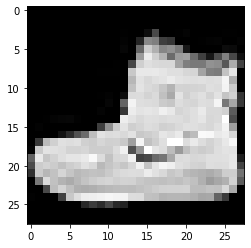

In [8]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape(28,28), cmap="gray")
idx2clas[y_train[0].item()] 

Now we will transform data into tensor format.

In [9]:
import torch

# transform 1. convert to tensor
x_train, x_valid = map(lambda p: torch.tensor(p, dtype=torch.float32), (x_train, x_valid))
y_train, y_valid = map(lambda p: torch.tensor(p, dtype=torch.int64), (y_train, y_valid))


And normalize the image tensor. This is standard step in image processing which helps faster convergence.

In [10]:
# transform 2. normalize images
mean = x_train.mean()
std = x_train.std()
print(f"mean: {mean}, std: {std}")
x_train, x_valid = map(lambda p: (p - mean)/std, (x_train, x_valid))


mean: 72.9342041015625, std: 90.02118682861328


In [11]:
x_train.mean(), x_train.std()

(tensor(-4.0474e-07), tensor(1.0000))

In [12]:
x_valid.mean(), x_valid.std()

(tensor(0.0023), tensor(0.9984))

> Important: we need to set dtype=torch.float32 in order to be able to make matrix multiplication later on with  linear layer's weight matrix. Two tensor have to have the same datatype and device so as to do operations.

And finally, load data into an object to make it easily accessible. This task normally is handled by Pytorch `DataLoader` object but since we are building everything from scratch, let's use the traditional `for loop` to access batches of data.

In [60]:
# c. load batches of data
batch_size = 64
nr_iters = len(x_train) // batch_size

for i in range((nr_iters + 1)):
    start_index = i * batch_size
    end_index = start_index + batch_size
    xs = x_train[start_index:end_index]
    ys = y_train[start_index:end_index]
    print(xs.shape)
    print(ys.shape)


## Create and training simple neural net from scratch

For our 10-class classification problem, we will create a simple network which contains only a linear layer and a non-linear layer - softmax. 

In general, a layer contains 2 parts: 
- `data`: represents the state of that layer. In particular, they are weight and bias - learnable parameters which are updated/learned during training process. 
- `transformation`: the operation which transform layer's input to output using learnable parameters.

`Linear layers`'s data is `weight matrix tensor` and `bias tensor` while its transformation is the `matrix multiplication`. The weight matrix defines a linear function that maps a 1-dimentional tensor with 784 elements to a 1-dimensional tensor with 10 elements. 

Briefly remind the mathematical function of linear layer.   
Given $A$, $x$, $b$, $y$ are `Weight matrix tensor`, `Input tensor`, `Bias tensor` and `Output tensor`, respectively. Mathematical notation of the linear transformation is:
\begin{equation}
y=A x+b
\end{equation}

We will initialize the weight matrix tensor following the recommendation from [Xavier initialisation paper](https://arxiv.org/abs/1502.01852). This paper tackled the problem with randomly initialized weight drawn from Gaussian distribution which caused hard convergence of deep network.
> Tip: 
    - we set `requires_grad` after initialization, since we don't want that step included in the gradident. 
    - The trailing `_` in Pytorch signifies that the operation is performed in-place.

In [13]:
import math

weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias    = torch.zeros(10, requires_grad=True)

Thanks to Pytorch's ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model.   
The log_softmax function is implemented using `log-sum-exp trick` for numerically stable. We will not go to detail this trick but you can go [here](https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/) or [here](https://www.tensorflow.org/api_docs/python/tf/nn/log_softmax) for details explanation. The formular for this trick is: 
$$ log\_softmax(x) = x - logsumexp(x) $$


In [14]:
def log_softmax(x): return x - x.exp().sum(-1).log().unsqueeze(-1)
def simplenet(x): return log_softmax(x @ weights + bias)

> Tip: `@` stand for dot product operation.

Now we have had a simple network and data setup. Let's try to predict a batch. 

In [15]:
bs = 16
xs, ys = x_train[:bs], y_train[:bs]
preds = simplenet(xs)
preds.shape

torch.Size([16, 10])

In [16]:
preds

tensor([[-1.4405, -3.5105, -2.7565, -1.4291, -2.4875, -2.0924, -4.0225, -4.0119,
         -2.5381, -2.2188],
        [-4.8259, -3.7734, -2.0315, -2.3298, -0.9287, -2.6093, -3.6926, -2.2518,
         -1.9918, -5.2320],
        [-2.6215, -2.3225, -1.9596, -1.8593, -2.6342, -2.3268, -1.6219, -2.6988,
         -2.7874, -3.3023],
        [-3.2222, -3.1183, -1.6531, -1.5975, -2.2923, -2.7484, -1.7113, -2.3899,
         -2.6972, -4.0560],
        [-4.0472, -4.3383, -2.3563, -1.5838, -0.7511, -2.6288, -3.0189, -3.5576,
         -3.2544, -4.6537],
        [-2.2369, -3.2984, -0.9843, -2.8722, -2.3741, -1.8116, -4.1416, -5.1253,
         -2.9522, -2.3493],
        [-1.8748, -4.8596, -2.7152, -1.2111, -3.2741, -2.0744, -2.4669, -2.8398,
         -2.7450, -2.2655],
        [-2.7887, -4.9238, -1.3429, -3.5693, -2.6362, -1.4553, -5.4066, -6.6005,
         -3.2211, -1.2336],
        [-3.9236, -2.5255, -2.9410, -0.6889, -4.0574, -3.9685, -2.6249, -1.6157,
         -4.2080, -3.7726],
        [-1.7502, -

What we did above is one `forward pass`, we load a batch of image add feed it through the network.   
The result will not be better than a random prediction at this stage because we start with random weights.

As we see in the `preds` tensor, it contains not only the tensor values but also a gradient function. As mentioned in part 1, pytorch use dynamic computational graph to track function operations that occur on tensors. These graph are then used to compute the derivatives. 



In [17]:
preds.grad_fn

Now we need to define the loss function which is the model's objective. Our weights and bias will be updated in the direction which make this loss decreased. One of the most common loss function is `negative log-likelihood`.

In [18]:
def nll(input, target):
    return -input[range(input.shape[0]), target.tolist()].mean()

loss_function = nll

loss_function(preds, ys)

tensor(2.9355, grad_fn=<NegBackward>)

Next, We will define a `metric`. During the training, reducing the `loss` is what our model tries to do but it is hard for us, as human, can intuitively understand how good the weights set are along the way. So we need a human-interpretable value which help us understand the training progress and it is the `metric`.   


In [19]:
def accuracy(input, target): 
    return (torch.argmax(input, dim=1) == target).float().mean()

accuracy(preds, ys)

tensor(0.1250)

We are now ready to begin the training process. The training process is an iterative process which including following steps:
1. **Get batch from the training set**.  
    - Since we have 60,000 samples in our training set, we will have 60,000 / 100 = 600 iterations. Something to notice, batch_size will directly impact to the number of times the weights updated. In our case, the weights will be updated 600 times by the end of each loop. So far, there is no rule-of-thump for selecting the value of batch size so we still need to do trial and error to figure out the best value.
> Important: to be simple, I am not shuffling the training set at this stage. In reality, the training set should be shuffled to prevent correlation between batches and overfitting. If we keep feeding the network batch-by-batch in order, the network might remember this order and causes overfitting with this order. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data. 
    
2. **Pass batch to network.**

3. **Calculate the loss (difference between the predicted values and the true values).**

4. **Calculate the gradient of the loss function w.r.t the network's weights.**
   - Calculating the gradients is very easy using PyTorch. Since PyTorch has created a computation graph under the hood. As our tensor flowed forward through our network, all of the computations where added to the graph. The computation graph is then used by PyTorch to calculate the gradients of the loss function with respect to the network's weights.
   
5. **Update the weights using the gradients to reduce the loss.**
    - The gradients calculated from step 4 are used by the optimizer to update the respective weights. 
    - We have disabled PyTorch gradient tracking at this step because we don't want these actions to be recorded for our next calculation of the gradient. There are many ways to disable this functionality, please check `Random topics` at the end of notebook for more information.
    - After updating the weight, we need to zero out the gradients because the gradients will be calculated and added to the grad attributes of our network's parameters after calling loss.backward() at the next iteration.

6. **Repeat steps 1-5 until one epoch is completed.**

7. **Calculate mean loss of validation set**
> Note: We can use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

8. **Repeat steps 1-6 for as many epochs required to reach the minimum loss.**

We will use `Stochastic Gradient Descent (SGD)` optimizer to update our learnable parameters during training. `lr` tells the optimizer how far to step in the direction of minimizing loss function.



In [20]:
lr = 0.01    
epochs = 5  
batch_size = 64     

nr_iters = len(x_train) // bs
for epoch in range(epochs):
    for i in range((nr_iters + 1)):
        # step 1. get batch of training set
        start_index = i * batch_size
        end_index = start_index + batch_size
        xs = x_train[start_index:end_index]
        ys = y_train[start_index:end_index]
        # step 2. pass batch to network
        preds = simplenet(xs)
        # step 3. calculate the loss
        loss = loss_function(preds, ys)
        # step 4. calculate the gradient of the loss w.r.t the network's parameters
        loss.backward()
        with torch.no_grad(): 
            # step 5. update the weights using SGD algorithm
            weights -= lr * weights.grad
            bias    -= lr * bias.grad
            weights.grad.zero_()          
            bias.grad.zero_()
    # step 6. calculate mean of valid loss after each epoch to see the improvement
    batch_size_valid = batch_size * 2
    nr_iters_valid = len(x_valid) // batch_size_valid
    total_loss = 0
    total_acc  = 0    
    with torch.no_grad():
        for i in range((nr_iters_valid + 1)):
            start_index = i * batch_size_valid
            end_index = start_index + batch_size_valid
            xs = x_valid[start_index:end_index]
            ys = y_valid[start_index:end_index]
            preds = simplenet(xs)
            loss = loss_function(preds, ys) 
            total_loss += loss.item() * xs.shape[0] 
            
            acc = accuracy(preds, ys)
            total_acc += acc.item() * xs.shape[0]
    print(f"epoch {epoch}, valid_loss {total_loss / len(x_valid)}, accuracy {total_acc / len(x_valid)}")
            

epoch 0, valid_loss 0.5325431520462036, accuracy 0.8139
epoch 1, valid_loss 0.49808417506217956, accuracy 0.8252
epoch 2, valid_loss 0.48265715327262876, accuracy 0.8305
epoch 3, valid_loss 0.4735100971221924, accuracy 0.8335
epoch 4, valid_loss 0.46733067717552185, accuracy 0.8356


During the first training epoches, the valid loss should decrease and the accuracy should increase. Otherwise, you did something wrong.

## Refactor neural network with Pytorch modules

We will gradually refactor our simple net with Pytorch built-in modules, so that it does the same thing as before but start taking advantage of Pytorch's modules to make it more concise, more understandable and/or flexible.  
To make things more gradual and more understandable, the refactoring will be divided into 3 stages.
 

### Refactor stage 1 
 - Refactor loss fuction with `torch.nn.functional.cross_entropy` function.
 - Refactor model with `nn.Module`, `nn.Parameter` class.
 - Refactor optimization algorithm with `model.parameters` and `model.zero_grad` method.

We first will refactor the `log_softmax` and `nll` method with Pytorch built-in function `torch.nn.functional.cross_entropy` that combines the two. So we can even remove the activation function from our model.

In [21]:
import torch.nn.functional as F

# old functions
# def log_softmax(x): return x - x.exp().sum(-1).log().unsqueeze(-1)
# def simplenet(x): return log_softmax(x @ weights + bias)

# new functions
loss_function = F.cross_entropy
def simplenet(x): return x @ weights + bias

Next we will refactor our `simplenet` using `torch.nn` module.

`torch.nn` is PyTorch’s neural network (nn) library which contains the primary components to construct network's layers. Within the `torch.nn` package, there is a class called `Module`, and it is the base class for all of neural network modules, including layers. All of the layers in PyTorch need to extend this base class in order to inherit all of PyTorch’s built-in functionality within the `nn.Module` class.  
> Note: `nn.Module` (uppercase M) is a Pytorch specific concept, and is a class we'll be using a lot. Do not confuse with the Python concept of a (lowercase m) `module`, which is a file of Python code that can be imported.

In order to create model using `nn.Module`, we have 3 essential steps:
1. Create a neural network class that extends the `nn.Module` base class.
2. Define the network's layers as class attributes in `__init__` method.
    - The layers's learnable parameters are initialized in this step. But they need to be wrapped in `nn.Parameters` class in order to help `nn.Module` know those are learnable parameter. The weight tensor inside every layer is an instance of this `Parameter` class. PyTorch’s `nn.Module` class is basically looking for any attributes whose values are instances of the `Parameter` class, and when it finds an instance of the parameter class, it keeps track of it. Take a look at `Random topics` section for more detail information about network parameters.
3. Define the network's transformation (operation) in `forward` method.
    - Every Pytorch `nn.Module` has a `forward()` method and so when we are building layers and networks, we must provide an implementation of the `forward()` method. The forward method is the actual transformation.
    - The tensor input is passed forward though each layer transformation until the tensor reaches the output layer. The composition of all the individual layer forward passes defines the overall forward pass transformation for the network. The goal of the overall transformation is to transform or map the input to the correct prediction output class, and during the training process, the layer weights (data) are updated in such a way that cause the mapping to adjust to make the output closer to the correct prediction.
    - When we implement the forward() method of our nn.Module subclass, we will typically use layers'attributes and functions from the `nn.functional` package. This package provides us with many neural network operations that we can use for building layers. In fact, many of the nn.Module layer classes use nn.functional functions to perform their operations.

In [22]:
import math
import torch.nn as nn

# old codes
# weights = torch.randn(784,10) / math.sqrt(784)
# weights.requires_grad_()
# bias    = torch.zeros(10, requires_grad=True)
# def simplenet(x): return log_softmax(x @ weights + bias)

# new code
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias    = nn.Parameter(torch.zeros(10))
        
    def forward(self, x):
        return x @ self.weights + self.bias
    
simplenet = SimpleNet()

One thing to point out that Pytorch neural network modules are `callable Python objects`. It means we can call the `simplenet` as it was a function.   
What makes this possible is that PyTorch module classes implement a special Python function called `__call__()`. which will be invoked anytime the object instance is called. After the object instance is called, the `__call__()` method is invoked under the hood, and the `__call__()` in turn invokes the `forward()` method. Instead of calling the `forward()` method directly, we call the object instance. This applies to all PyTorch neural network modules, namely, networks and layers.

In order to access the model parameters, we can use `parameters()` or `named_parameters()` method. Next we will refactor optimization algorithm using `nn.Module.parameters` and `nn.Module.zero_grad` method. In addition, we also bring training loop inside a function for easier reuse.

In [23]:
lr = 0.01    
epochs = 5  
batch_size = 64     

nr_iters = len(x_train) // bs
for epoch in range(epochs):
    for i in range((nr_iters + 1)):
        # step 1. get batch of training set
        start_index = i * batch_size
        end_index = start_index + batch_size
        xs = x_train[start_index:end_index]
        ys = y_train[start_index:end_index]
        # step 2. pass batch to network
        preds = simplenet(xs)
        # step 3. calculate the loss
        loss = loss_function(preds, ys)
        # step 4. calculate the gradient of the loss w.r.t the network's parameters
        loss.backward()
        with torch.no_grad(): 
            # step 5. update the weights using SGD algorithm
            # old code
            # weights -= lr * weights.grad
            # bias    -= lr * bias.grad
            # weights.grad.zero_()          
            # bias.grad.zero_()

            # new code
            for p in simplenet.parameters(): p -= lr * p.grad
            simplenet.zero_grad()


    # step 6. calculate mean of valid loss after each epoch to see the improvement
    batch_size_valid = batch_size * 2
    nr_iters_valid = len(x_valid) // batch_size_valid
    total_loss = 0
    total_acc  = 0
    with torch.no_grad():
        for i in range((nr_iters_valid + 1)):
            start_index = i * batch_size_valid
            end_index = start_index + batch_size_valid
            xs = x_valid[start_index:end_index]
            ys = y_valid[start_index:end_index]
            preds = simplenet(xs)
            loss = loss_function(preds, ys) 
            total_loss += loss.item() * xs.shape[0] 

            acc = accuracy(preds, ys)
            total_acc += acc.item() * xs.shape[0]
    print(f"epoch {epoch}, valid_loss {total_loss / len(x_valid)}, accuracy {total_acc / len(x_valid)}")


epoch 0, valid_loss 0.5341379848957062, accuracy 0.8131
epoch 1, valid_loss 0.49990872111320495, accuracy 0.8275
epoch 2, valid_loss 0.48446780610084533, accuracy 0.8317
epoch 3, valid_loss 0.47528300595283507, accuracy 0.8343
epoch 4, valid_loss 0.4690569020748138, accuracy 0.8355


Ok so we have finished refactor stage 1. Let's move to refactor stage 2.

### Refactor stage 2
 - Refactor model with `nn.Linear` class.
 - Refactor data setup with `torch.utils.data.TensorDataset`, `torch.utils.data.DataLoader`.
 - Refactor optimization algorithm with `torch.optim` module.


Pytorch `nn.Linear` class does all the things that we have done for linear layer, including intialize learnable parameters and define linear operation. 
>Note: We used the abbreviation `fc` below because linear layers are also called fully connected layers or dense layer.    
So `linear` = `dense` = `fully connected.`


In [47]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)
    
    def forward(self, x):
        return self.fc(x)
    
simplenet = SimpleNet()    
simplenet

SimpleNet(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

> Note: we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.


Next is `Dataset` and `DataLoader`.  

`torch.utils.data.Dataset` is an abstract class for representing a dataset. An abstract class is a Python class that has methods we must implement, in our case are `__getitem__` and `__len__`. In order to create a custom dataset, we need to subclass the `Dataset` class and override `__len__`, that provides the size of the dataset, and `__getitem__`, supporting integer indexing in range from 0 to len(self) exclusive. Upon doing this, our new subclass can then be passed to the a PyTorch DataLoader object.  

PyTorch’s `TensorDataset` is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice `along the first dimension of a tensor`. This will make it easier to access both the independent and dependent variables in the same line as we train.  
> Note: we can douple batch size of valid set because we do not need to calculate gradient for it and it can handle larger batch size comparing to training set.

`torch.utils.data.DataLoader` is responsible for managing batches. It makes life easier to iterate over batches.
We can create a `DataLoader` from any `Dataset`. 

In [25]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 64     

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2, shuffle=False)

The code in training loop is now changed from

```
for i in range((nr_iters + 1)):
    # step 1. get batch of training set
    start_index = i * batch_size
    end_index = start_index + batch_size
    xs = x_train[start_index:end_index]
    ys = y_train[start_index:end_index]
    # step 2. pass batch to network
    preds = simplenet(xs)
```
to

```
for xs,ys in train_dl:
    preds = simplenet(xs)
```

And `torch.optim` package.  
This module provides various optimization algorithms. Its API provides `step` and `zero_grad` method for weight updating and zero out gradient which will help us refactor our code further.

In [26]:
from torch import optim

lr = 0.01    
epochs = 5  

simplenet = SimpleNet()
opt = optim.SGD(simplenet.parameters(), lr=lr)

for epoch in range(epochs):
    simplenet.train()
    for xs,ys in train_dl:
        preds = simplenet(xs)
        loss = loss_function(preds, ys)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    simplenet.eval()
    with torch.no_grad():
        total_loss = sum(loss_function(simplenet(xs),ys)*len(xs)  for xs, ys in valid_dl)
        total_acc = sum(accuracy(simplenet(xs),ys)*len(xs) for xs, ys in valid_dl)
        
    print(f"epoch {epoch}, valid_loss {total_loss / len(x_valid)}, accuracy {total_acc / len(x_valid)}")


epoch 0, valid_loss 0.5226423740386963, accuracy 0.8163999915122986
epoch 1, valid_loss 0.49401089549064636, accuracy 0.82669997215271
epoch 2, valid_loss 0.48364755511283875, accuracy 0.8306000232696533
epoch 3, valid_loss 0.4771580994129181, accuracy 0.8323000073432922
epoch 4, valid_loss 0.4616956412792206, accuracy 0.8371000289916992


Done!  
We have finished the whole processes. Thanks to Pytorch built-in modules, our training loop is now dramatically smaller and easier to understand.   
The refactor stage 3 does not introduce any new Pytorch modules. It is only an bonus step which help the code a bit cleaner and less code.

### Refactor stage 3

`get_data` returns dataloaders for the training and validation sets.



In [38]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs, shuffle=False)
    )

`get_model` returns instance of our model and the optimizer.


In [39]:
def get_model(model, lr):
    m = model()
    opt = optim.SGD(m.parameters(), lr=lr)
    return m, opt


Since we go through a similar process twice of calculating the loss for both the training set and the validation set, let’s make that into its own function, `loss_batch`, which computes the loss for one batch.  
We pass an optimizer in for the training set, and use it to perform backprop. For the validation set, we don’t pass an optimizer, so the method doesn’t perform backprop.



In [40]:
def loss_batch(model, loss_func, xs, ys, opt=None, metric=None):
    loss = loss_func(model(xs), ys)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    if metric is not None:
        acc = metric(model(xs), ys)
        return loss.item(), acc.item(), len(xs)
    else:
        return loss.item(), len(xs)

`fit` runs the necessary operations to train our model and compute the training and validation losses for each epoch.



In [44]:
import numpy as np

def fit(epochs, model, loss_func, metric, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xs, ys in train_dl:
            loss_batch(model, loss_func, xs, ys, opt)
            
        model.eval()
        with torch.no_grad():
            losses, accs, nums =  zip(*[loss_batch(model, loss_func, xs, ys, metric=metric) for xs,ys in valid_dl])
            
        total_loss = np.sum(np.multiply(losses, nums))
        total_acc  = np.sum(np.multiply(accs, nums))
        print(f"epoch {epoch}, valid_loss {total_loss / np.sum(nums)}, accuracy {total_acc / np.sum(nums)}")


In [46]:
bs = 64
lr = 0.01
epochs = 5

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model(model=SimpleNet, lr=lr)
fit(epochs, model, loss_function, accuracy, opt, train_dl, valid_dl)

epoch 0, valid_loss 0.5245783556461334, accuracy 0.8162
epoch 1, valid_loss 0.49596426906585694, accuracy 0.8261
epoch 2, valid_loss 0.4808829068660736, accuracy 0.8334
epoch 3, valid_loss 0.47098530049324033, accuracy 0.8347
epoch 4, valid_loss 0.4786785946369171, accuracy 0.831


Done!   
Now we can use refactored functions to train a wide variety of models.   
In part 3, we will use it to train a CNN (Convolutional Neural Network)

## Random topics

### Disabling PyTorch Gradient Tracking


Get predictions for the entire training set
Note at the top, we have annotated the function using the @torch.no_grad() PyTorch decoration. 
This is because we want this functions execution to omit gradient tracking. This is because gradient 
tracking uses memory, and during inference (getting predictions while not training) there is no need to 
keep track of the computational graph. The decoration is one way of locally turning off the gradient tracking
feature while executing specific functions. We specifically need the gradient calculation feature anytime we 
are going to calculate gradients using the backward() function. Otherwise, it is a good idea to turn it off
because having it off will reduce memory consumption for computations, e.g. when we are using networks for 
predicting (inference).

As another example, we can use Python's with context manger keyword to specify that a specify block of code
should exclude gradient computations.
Both of these options are valid

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        imgs, lbs = batch
        
        preds = model(imgs)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

# Locally Disabling PyTorch Gradient Tracking
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(model, prediction_loader)

For more information, please check [here](https://pytorch.org/docs/stable/notes/autograd.html)

### log-sum-exp trick
https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/  
https://www.tensorflow.org/api_docs/python/tf/nn/log_softmax  
https://stackoverflow.com/questions/44081007/logsoftmax-stability

come back later!

## Reference

Some good sources:
- [pytorch zero to all](https://github.com/hunkim/PyTorchZeroToAll)
- [deeplizard](https://deeplizard.com/learn/video/v5cngxo4mIg)
- [effective pytorch](https://github.com/vahidk/EffectivePyTorch?fbclid=IwAR1MhsjnjccWy6dIVtibFOCZbWhLtAj5pSTobnkUDxw_gHgfEswnVzqrKQ0#torchscript)
- [what is torch.nn really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)
- [recommend walk with pytorch](https://forums.fast.ai/t/getting-comfortable-with-pytorch-projects/28371)
- [official tutorial](https://pytorch.org/tutorials/)
- [DL(with Pytorch)](https://github.com/Atcold/pytorch-Deep-Learning)
- [Pytorch project template](https://github.com/moemen95/PyTorch-Project-Template)
- [nlp turorial with pytorch](https://github.com/graykode/nlp-tutorial)
- [UDACITY course](https://www.udacity.com/course/deep-learning-pytorch--ud188)
- [awesome pytorch list](https://github.com/bharathgs/Awesome-pytorch-list)
- [deep learning with pytorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf)
- others:
    - https://medium.com/pytorch/get-started-with-pytorch-cloud-tpus-and-colab-a24757b8f7fc
    - Grokking Algorithms: An illustrated guide for programmers and other curious people 1st Edition